In [ ]:
import torch
import cv2
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from model.MDN_hourglass import get_mixture_hourglass
from model.hourglass import get_hourglass
import seaborn as sns
from utils.utils import count_parameters
from utils.coco import COCO_eval,COCO_NAMES
import random
from utils.image import transform_preds
from utils.post_process import ctdet_decode

In [ ]:
device='cuda'
COCO_COLORS = sns.color_palette('hls', len(COCO_NAMES))

## Test Baseline 

In [ ]:
model = get_hourglass['large_hourglass'].to(device)
path = './ckpt/baseline/{}.pt'.format(0)
state_dict=torch.load(path)
model.load_state_dict(state_dict)
count_parameters(model)

Total num of param = 191.284008 M


In [ ]:
dataset = COCO_eval(root='./cocodataset',split='test')

rnd_idx = random.choice([i for i in range(dataset.__len__())])
demo_data = dataset.__getitem__(rnd_idx)
img_path = dataset.images[rnd_idx]
img_path =  os.path.join(dataset.img_dir, dataset.coco.loadImgs(ids=[img_path])[0]['file_name'])
demo_image = cv2.imread(img_path) #[BGR]
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_BGR2RGB)
print(rnd_idx)
print(demo_image.shape)

==> initializing coco 2017 test data.
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loaded 20288 test samples
8209
(427, 640, 3)


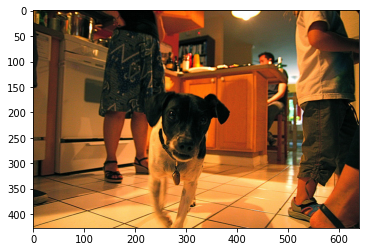

In [ ]:
plt.imshow(demo_image)

In [ ]:
inputs = demo_data[1][1]['image']
inputs = torch.FloatTensor(inputs)
print(inputs.size())
output = model(inputs.to(device))[-1]
dets = ctdet_decode(*output)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[2])[0]

top_preds = {}
dets[:, :2] = transform_preds(dets[:, 0:2],
                            demo_data[1][1]['center'],
                            demo_data[1][1]['scale'],
                            (demo_data[1][1]['fmap_w'], demo_data[1][1]['fmap_h']))
dets[:, 2:4] = transform_preds(dets[:, 2:4],
                            demo_data[1][1]['center'],
                            demo_data[1][1]['scale'],
                            (demo_data[1][1]['fmap_w'], demo_data[1][1]['fmap_h']))
cls = dets[:, -1]
for j in range(dataset.num_classes):
    inds = (cls == j)
    top_preds[j + 1] = dets[inds, :5].astype(np.float32)
    top_preds[j + 1][:, :4] /= 1
detections = [top_preds]

torch.Size([1, 3, 512, 768])


In [ ]:
bbox_and_scores = {}
for j in range(1, 81):
    bbox_and_scores[j] = np.concatenate([d[j] for d in detections], axis=0)
scores = np.hstack([bbox_and_scores[j][:, 4] for j in range(1, 81)])

if len(scores) > 100:
    kth = len(scores) - 100
    thresh = np.partition(scores, kth)[kth]
    for j in range(1, 81):
        keep_inds = (bbox_and_scores[j][:, 4] >= thresh)
        bbox_and_scores[j] = bbox_and_scores[j][keep_inds]

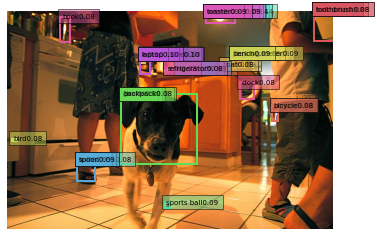

In [ ]:
fig = plt.figure(0)
colors = COCO_COLORS
names = COCO_NAMES
plt.imshow(demo_image)
for lab in bbox_and_scores:
    for boxes in bbox_and_scores[lab]:
        x1, y1, x2, y2, score = boxes
    if score > 0.07:
        plt.gca().add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                                    linewidth=2, edgecolor=colors[lab], facecolor='none'))
        plt.text(x1 + 3, y1 + 3, names[lab] + '%.2f' % score,
                bbox=dict(facecolor=colors[lab], alpha=0.5), fontsize=7, color='k')

fig.patch.set_visible(False)
plt.axis('off')
#plt.savefig('demo_results.png', dpi=300, transparent=True)
plt.show()

## Plot HeatMap

In [ ]:
heatmap = torch.sigmoid(output[0])
m = torch.nn.Upsample(scale_factor=(4,4), mode='nearest')
heatmap = m(heatmap).squeeze(0)
heatmap = torch.sum(heatmap,dim=0)/80
heatmap = heatmap.detach().cpu().numpy()
heatmap = cv2.resize(heatmap, (640,427))

(427, 640, 3) (427, 640)


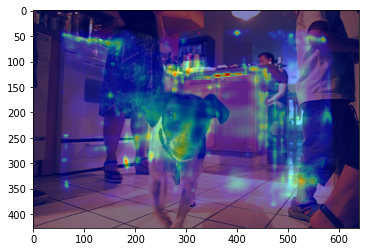

In [ ]:
print(demo_image.shape,heatmap.shape)
plt.imshow(demo_image)
plt.imshow(heatmap,alpha=0.5,cmap='jet')